In [1]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Ground state of the system(function $u(0, x) = \varphi(x)$)

In [2]:
# I took the e^(-x^2) as an example
def phi(x):
    return np.exp(-x**2)

Solve interval:

 a -- left boudary
 
 b -- right boundary
 
 n -- number of steps
 
 ht -- time step

In [59]:
a = -3.5
b = 3.5


# h -- spatial step 

h = 0.05

n = int((b-a+h)/h)

# ht -- time step
ht = 0.5

# time boundaries
t_left = 0

t_right = 40


m = int((t_right-t_left)/ht)

Making a grid

In [60]:
#grid = np.arange(a,b,h)

time_grid = np.arange(t_left,t_right, ht)

len(time_grid)

80

## Using the formula from the paper

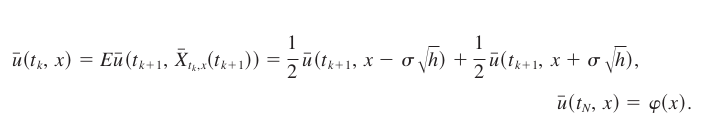
The first time of calculation will be following:

As we see we can calculate all the grid using the highest layer.(in out case $\sigma =\sqrt{2}$, actually I'm not sure :( )



**Short description of method:**

On the i-st layer on time we calculate $u^i_n = \dfrac{1}{2} \left( u^{i+1}_{n-\sigma \sqrt{h}} +  u^{i+1}_{n+\sigma \sqrt{h}} \right)$. We go down by time.

We can find how our grid is going to decrease using this method(because in every time step we won't include the boundaries of previous layer)

In [35]:
np.sqrt(2*h)

0.1

In [36]:
np.sqrt(2*h)/h

20.0

So approximation will be the following
$$u^k_n = \dfrac{u^{k+1}_{n-20}+u^{k+1}_{n+20}}{2}$$

In [37]:
delta = np.sqrt(2*h)*(t_right-t_left)/ht
delta

40.0

As we can see for solution on [-3,3] we need to take spartial boundaties on $\approx$ [-43.5, 43.5].

In [38]:
a_reshaped = -3.5 - delta
b_reshaped = 3.5 + delta
grid = np.arange(a_reshaped, b_reshaped,h)

n = int((b_reshaped-a_reshaped)/h)

In [39]:
u = np.zeros((m,n))

u[m-1, :] = phi(grid) 

# We will use tmp_grid to diminish initial one
tmp_grid = grid.copy()

for i in range(m-2,-1,-1):
    new_grid = tmp_grid[20:-20]
    for j in range(len(new_grid)):
        u[i, j+20*(m-i-1)] = (u[i+1, j+20*(m-i-2)] + u[i+1, j+20*(m-i)])/2
    tmp_grid = new_grid

Now we need to narrow u on the solution area.

In [40]:
# the number of elem was calculated in the u[0]
(grid.shape[0] - tmp_grid.shape[0])/2

7980.0

In [41]:
u_reshaped = u[:,7980:-7980]

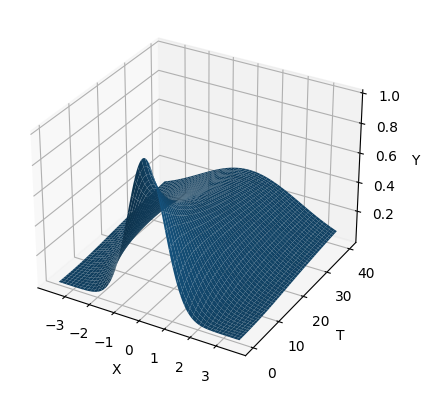

In [42]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
x, t = np.meshgrid(tmp_grid, -(time_grid-time_grid.max()))
    
ax.plot_surface(np.array(x), np.array(t), np.array(u_reshaped))
ax.set_xlabel('X')
ax.set_ylabel('T')
ax.set_zlabel('Y')
plt.show()   

Let's compare with exact solution:

The exact solution with $\varphi(x) = e^{-x^2}$ will be

$$u(x,t) = \dfrac{e^{\dfrac{x^2}{4t \sigma^2 +1}}}{\sqrt{4t \sigma^2+1}}$$

100%|██████████| 3999/3999 [00:00<00:00, 76578.65it/s]


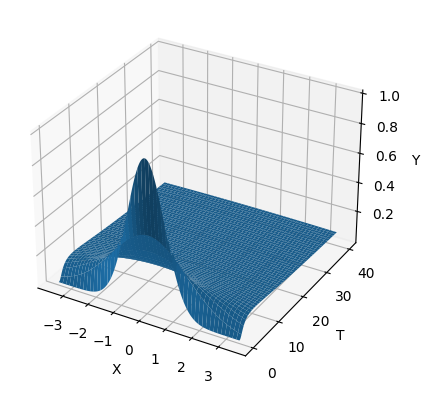

In [204]:
h_real = 0.01

x_grid_real = np.arange(a, b, h_real)

tau_real = 0.01

time_grid_real = np.arange(t_left, t_right, tau_real)

def phi_true(t, x) :
    return np.exp( - x ** 2 / (1 + 4 * t ) ) / np.sqrt (1 + 4 * t )


M = len(x_grid_real)

N = len(time_grid_real)
    
y_real = np.array([[0.0]*M]*N)
y_real[0] = np.exp(- x_grid_real**2)
for j in tqdm(range(N-1)):
    y_real[j+1] = phi_true(time_grid_real[j], x_grid_real)

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
x, t = np.meshgrid(x_grid_real, time_grid_real)
    
ax.plot_surface(np.array(x), np.array(t), np.array(y_real))
ax.set_xlabel('X')
ax.set_ylabel('T')
ax.set_zlabel('Y')
plt.show()   

As we can see solution with this way isn't quite good. So let's try a way with random walk and equation

**Actually there is a funny think -- is we put lower pace into heat equation we will get very nice results**


100%|██████████| 3999/3999 [00:00<00:00, 78142.35it/s]


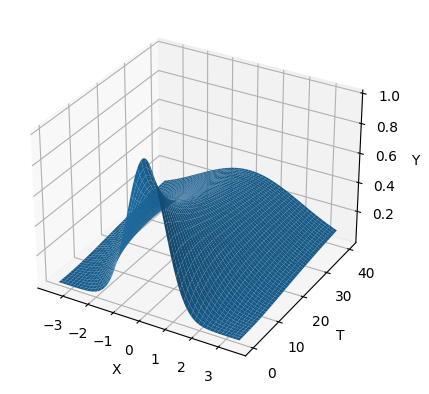

In [205]:
h_real = 0.01

x_grid_real = np.arange(a, b, h_real)

tau_real = 0.01

time_grid_real = np.arange(t_left, t_right, tau_real)

def phi_true(t, x) :
    return np.exp( - x ** 2 / (1 + 4 * t/20) ) / np.sqrt (1 + 4 * t/20 )


M = len(x_grid_real)

N = len(time_grid_real)
    
y_real = np.array([[0.0]*M]*N)
y_real[0] = np.exp(- x_grid_real**2)
for j in tqdm(range(N-1)):
    y_real[j+1] = phi_true(time_grid_real[j], x_grid_real)

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
x, t = np.meshgrid(x_grid_real, time_grid_real)
    
ax.plot_surface(np.array(x), np.array(t), np.array(y_real))
ax.set_xlabel('X')
ax.set_ylabel('T')
ax.set_zlabel('Y')
plt.show()   

They almoust don't differ from each other!(at least by eye!) 

## Through random walk

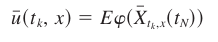

where $X_{k+1} = X_k + \sigma \sqrt{h} \xi_k, ~X_0 = x, ~P(\xi_k=\pm 1) = \dfrac{1}{2}.$

**Short description of method:**

Program creates i+1 random pathes from starting point from the grid and then makes i steps. Then takes last points of the steps and calculate averate of them. i is a number of previous steps. i varies from 0 to M(=size of time grid).

We will make tons of random pathes with the conditions that our interval in [-3.5, 3.5]. 

In [95]:
a = -3.5
b = 3.5

h = 0.05/2/2/2/2

grid = np.linspace(a,b,int((b-a)/h))
n =len(grid)

In [96]:
u = np.zeros((m,n))

# v -- velocity
v = 0.1

for i in tqdm(range(len(time_grid))):
    # Define parameters for the walk
    dims = 1
    step_n = i
    step_set = [-1, 1]
                                            
    
    number_of_pathes = i+1
    
    for j in range(len(grid)):
        average_phi = 0
        
        for path_number in range(number_of_pathes):
            # Path creating
            start = grid[j]
            origin = np.zeros((1,dims))+start
            step_shape = (step_n,dims)
            steps = np.random.choice(a=step_set, size=step_shape)*v*np.sqrt(ht)

            stop = np.concatenate([origin, steps]).sum()
#             path = np.concatenate([origin, steps]).cumsum(0)
#             start = path[:1]
#             stop = path[-1:]
            
            average_phi += phi(stop)
        u[m-i-1, j] = average_phi/number_of_pathes
        

100%|██████████| 80/80 [03:53<00:00,  2.92s/it]


In [98]:

y_real = np.zeros((m,n))
y_real[0] = np.exp(- grid**2)
for i in tqdm(range(len(time_grid))):
    y_real[i] = phi_true(time_grid_real[j], grid)

    
np.max(abs(y_real-u))

100%|██████████| 80/80 [00:00<00:00, 35357.67it/s]


0.28581011012581103

In [ ]:
0.3792483538327849
0.2732090331232264
0.22444808245562897
0.20518366377934538

In [90]:
np.log2((0.3792483538327849-0.2732090331232264)/(0.2732090331232264-0.22444808245562897))

1.1208011745676223

In [94]:
np.log2((0.2732090331232264-0.22444808245562897)/(0.22444808245562897-0.20518366377934538))

1.3397876018855484

Plot of the solution

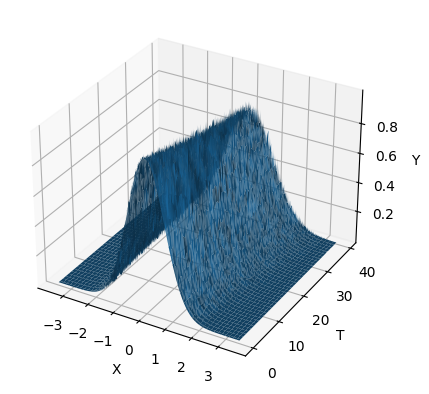

In [99]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
x, t = np.meshgrid(grid, -(time_grid-time_grid.max()))
    
ax.plot_surface(np.array(x), np.array(t), np.array(u))
ax.set_xlabel('X')
ax.set_ylabel('T')
ax.set_zlabel('Y')
plt.show()   

Time to compare to exact solution with the same speed!

100%|██████████| 3999/3999 [00:00<00:00, 77544.10it/s]


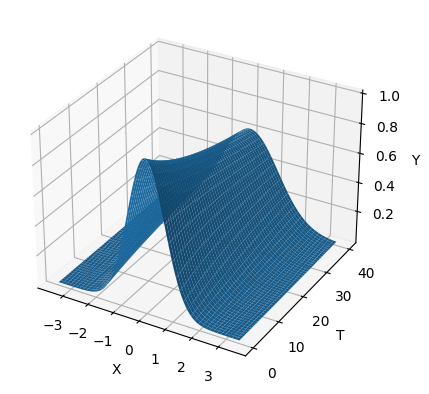

In [73]:
h_real = 0.01

x_grid_real = np.arange(a, b, h_real)

tau_real = 0.01

time_grid_real = np.arange(t_left, t_right, tau_real)

def phi_true(t, x) :
    return np.exp( - x ** 2 / (1 + 4 * t*0.01 ) ) / np.sqrt (1 + 4 * t*0.01 )


M = len(x_grid_real)

N = len(time_grid_real)
    
y_real = np.array([[0.0]*M]*N)
y_real[0] = np.exp(- x_grid_real**2)
for j in tqdm(range(N-1)):
    y_real[j+1] = phi_true(time_grid_real[j], x_grid_real)

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
x, t = np.meshgrid(x_grid_real, time_grid_real)
    
ax.plot_surface(np.array(x), np.array(t), np.array(y_real))
ax.set_xlabel('X')
ax.set_ylabel('T')
ax.set_zlabel('Y')
plt.show()   

Brilliantly!

## Extra question
Let's do an approximation research for  
$$u(t_k, x) = \dfrac{1}{2} u(t_{k+1},x-\sigma \sqrt{h})+ \dfrac{1}{2} u(t_{k+1},x+\sigma \sqrt{h})$$

Taylor series:
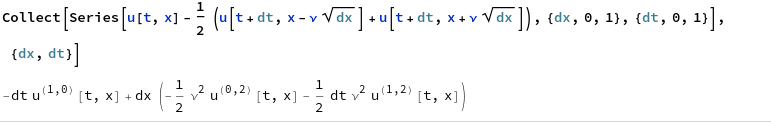

As we can see equations works if $h =\tau$.

## Extra code(not necessary to read)

Realization of 1 dimensional random walk

In [108]:
#1-dim random walk

dims = 1
step_n = i
step_set = [-1, 1]
    
    
start = grid[j]
origin = np.zeros((1,dims))+-3
step_shape = (step_n,dims)
steps = np.random.choice(a=step_set, size=step_shape)*v*np.sqrt(ht)
path = np.concatenate([origin, steps]).cumsum(0)
start = path[:1]
stop = path[-1:]

np.concatenate([origin, steps]).sum(0)

array([-2.96521495])